In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import manifold
import operator
import random
import matplotlib.pyplot as plt

In [ ]:
"""
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=12324)
cosine_embedding = embedding.fit_transform(dissimilarity_cosine)
cosine_embedding.shape
"""

In [415]:
cuisines = pd.read_csv("Cuisines.csv",header=None)
cuisines.columns = ['cuisine_key','cuisine']
recipes = pd.read_csv("recipes.csv")

In [417]:
recipes_data = recipes
recipe_columns = recipes_data.columns
recipe_columns = [ingredient.replace(' ','_') for ingredient in recipe_columns]
recipe_columns = [ingredient.replace('\'','') for ingredient in recipe_columns]
recipes_data.columns = recipe_columns
recipes_data.columns

Index(['acorn_squash', 'adobo', 'african_birdseye_chile_pepper', 'ale',
       'aleppo_pepper', 'alfalfa_sprouts', 'alfredo_sauce', 'allspice',
       'almond', 'almond_butter',
       ...
       'yeast', 'yellow_curry_paste', 'yellow_food_coloring',
       'yellow_split_pea', 'yellow_squash', 'yogurt', 'zaatar', 'zest',
       'zucchini', 'cuisine'],
      dtype='object', length=710)

In [419]:
#cosine similiarity Transformed filtered to get similiarty matrix between ingredients
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

recipes_data_drop = recipes_data.drop(["cuisine",'water','salt','baking_soda','baking_powder'], axis=1)
filtered = recipes_data_drop

train, test = train_test_split(filtered, test_size=0.4, random_state=1)
val, test = train_test_split(test, test_size=0.75, random_state=1)
filtered_train = train.to_numpy()
#feature reduction 95%
"""
if PCA_on == True:
    cuisine_pca = PCA(n_components=0.95,random_state=12345)
    recipes_data_drop = pd.DataFrame(cuisine_pca.fit_transform(filtered))
    """
dissimilarity_cosine = pairwise_distances(filtered_train.T, metric="jaccard")

C:\Users\akash\miniconda3\envs\mlp\lib\site-packages\sklearn\metrics\pairwise.py:1765: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [8]:
pd.set_option('display.max_columns', 1000)  # or 1000

# model built here

In [420]:
similarity_cosine = 1-dissimilarity_cosine # use 1 for similar, and 0 for not similar

In [422]:
### select K most similar ingredients for ingredient I (0 to end).

def top_K(K,I):
    
    similarity_cosine[I]
    ingredients_dict = {}
    
    for i,j in enumerate(similarity_cosine[I]):
        if not j==0:
            ingredients_dict[recipes_data_drop.columns[i]] = (j,i)
    ingredients_dict = dict(sorted(ingredients_dict.items(), key=operator.itemgetter(1), reverse = True))
    if K > len(ingredients_dict.items()):
        K=len(ingredients_dict.items())
    ingredients_dict = dict(list(ingredients_dict.items())[0:K])
    
    return ingredients_dict

def recommend_n_ingredients(R,K,n,dataset): # for a recipe R, returns a wei
    
    
    n_ingredients = similarity_cosine.shape[0]  
    r = np.array(dataset.iloc[R])
    a = np.zeros(n_ingredients)
    P = {}
    
    for I in range(0, n_ingredients):
        
        d = top_K(K,I) # get K most similar ingredients to ingredient I
        
        for i in d.items():
            
            a[i[1][1]]=i[1][0]
        
        P[dataset.columns[I]]=((r @ a)/sum(a),I)
    
    P = dict(sorted(P.items(), key=operator.itemgetter(1), reverse = True))
    P = dict(list(P.items())[0:n])
    
    rank=len(P.items())+1
    for i in P.items():
        rank-=1
        P[i[0]] = i[1]+(rank,)
    
    
    return P

In [425]:
recipes_index = 10
K_most_similar_ingredients = 100
N_recommendations = 50
d = recommend_n_ingredients(recipes_index,K_most_similar_ingredients, N_recommendations,train)
d

{'cayenne_pepper': (0.010473980569777547, 117, 50),
 'olive_oil': (0.010378151520063366, 419, 49),
 'garlic': (0.009987926890037576, 259, 48),
 'celery': (0.009911526255880076, 119, 47),
 'cauliflower': (0.009487345586724073, 116, 46),
 'celeriac': (0.008894326285382274, 118, 45),
 'celery_salt': (0.008883568399218354, 120, 44),
 'celery_seed': (0.008803004119765307, 121, 43),
 'celery_soup': (0.008627548937794757, 122, 42),
 'chanterelle_mushroom': (0.00854933847574783, 123, 41),
 'chard': (0.00847696681463454, 124, 40),
 'chayote': (0.008456448326459472, 125, 39),
 'parmesan_cheese': (0.008240076583071666, 438, 38),
 'potato_starch': (0.00780238371133229, 489, 37),
 'potato': (0.00780238371133229, 488, 36),
 'heavy_cream': (0.007431859198329931, 309, 35),
 'poultry_seasoning': (0.007331899618187986, 490, 34),
 'honey': (0.0069525518447757124, 316, 33),
 'powdered_sugar': (0.006782870821282363, 491, 32),
 'herb': (0.006560670065668431, 310, 31),
 'herbes_de_provence': (0.0064340599883

In [424]:
#the recipe in training set
train.iloc[recipes_index][train.iloc[recipes_index]==1]

cauliflower        1
garlic             1
heavy_cream        1
olive_oil          1
parmesan_cheese    1
potato             1
Name: 2374, dtype: int64

In [426]:
# is this a reasonable test or is this a sanity check?
# drop n ingredients from each recipe, measure the ability to reproduce the same recipe.
# N = number of samples

def run_test(N,KNN,N_rec,drop_n,dataset):
    #N is number of samples to tests (reduces computation time)
    K = KNN #K Most similar ingredients for recommender function
    N_recommendations = N_rec
    
    dataset_copy = dataset.copy(deep=True)
    #do a shorter validation

    ingredient_history = {}
    rank_raw = []
    rank_p_n = []
    rank_p_d = []
    in_top_10 = []
    in_top_5 = []
    
    
    for recipes_index in range(0,dataset_copy.shape[0]):
        
        # drop a drop_n amount of random ingredients from all recipes
        
        sample = random.sample(list(dataset.iloc[recipes_index][dataset.iloc[recipes_index]==1].index),drop_n)
        ingredient_history['Ingredient sample for recipe: {}'.format(recipes_index)] = (sample,recipes_index)
        dataset_copy.iloc[recipes_index][sample] = 0 # new database

    ingredient_history_reduced = random.sample(list(ingredient_history.items()),N)
    count=0
    for i in ingredient_history_reduced:
        count+=1
        sample = i[1][0]
        recipes_index = i[1][1]
        
        l = recommend_n_ingredients(recipes_index,K,N_recommendations,dataset)
        
        
        
        
        try:
            for i in sample:
                
                raw_percentile = l[i][2]/len(l.items()) #rank u,i
                rank_raw.append(raw_percentile)
                n = sum([(j[1][2]/len(l.items()))*j[1][0] for j in l.items()])
                d = sum([j[1][0] for j in l.items()])
                rank_p_n.append(n)
                rank_p_d.append(d)
                in_top_10.append(1)
                
                if i in [k for k in l.keys()][0:5]:
                    in_top_5.append(1)
                
        except:
            rank_raw.append(0)
            
            pass
        

    # recipes index is random integer between max length
    

    print('rank_raw, rank_p,top_10,top_5'.format(N_recommendations))
    return sum(rank_raw)/N, sum(rank_p_n)/sum(rank_p_d), sum(in_top_10)/N, sum(in_top_5)/N 
    
drop=1 #ingredients to drop
N=len(test) #samples to test
N_rec = 10 
KNN=250 #knn
top=10 # sample presence in top n predictions 
_run_test = run_test(N,KNN,N_rec,drop,test) # N is number of tests, drop is number of ingredients dropped, last index is dataset.
print(_run_test)

rank_raw, rank_p,top_10,top_5
(0.4004716981132073, 0.586716339854828, 0.6422955974842768, 0.3891509433962264)


In [411]:
len(test)

1272

rank_raw, rank_p,top_10,top_5
rank_raw, rank_p,top_10,top_5
rank_raw, rank_p,top_10,top_5
rank_raw, rank_p,top_10,top_5
rank_raw, rank_p,top_10,top_5
rank_raw, rank_p,top_10,top_5
rank_raw, rank_p,top_10,top_5
rank_raw, rank_p,top_10,top_5
rank_raw, rank_p,top_10,top_5
rank_raw, rank_p,top_10,top_5
rank_raw, rank_p,top_10,top_5


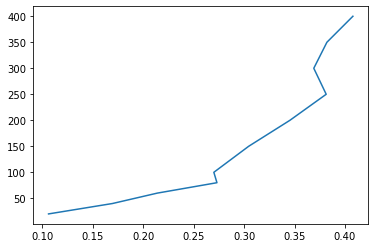

In [406]:
# find best K

seq = [20,40,60,80,100,150,200,250,300,350,400]

drop=1 #ingredients to drop
N=len(val) #samples to test (computation reduce)
N_rec = 10 #Number of recommendations

rank_raw = []
rank_p = []
top_10 = []
top_5 = []

for KNN in seq:
    l=run_test(N,KNN,N_rec,drop,val)
    rank_raw.append(l[0])
    rank_p.append(l[1])
    top_10.append(l[2])
    top_5.append(l[3])
    
plt.plot(rank_raw,seq)

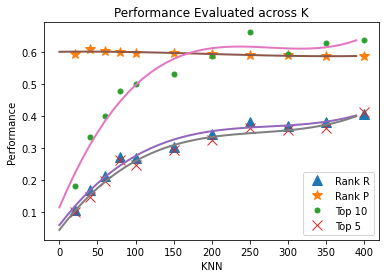

In [428]:
import numpy as np
import matplotlib.pyplot as plt

_seq = [[20],[40],[60],[80],[100],[150],[200],[250],[300],[350],[400]] #just this to change
# Set up and plot the dataset
X = np.array(_seq)
yy = np.array(rank_raw) # N,
yy2 = np.array(rank_p)
yy3 = np.array(top_10)
yy4 = np.array(top_5)

plt.clf()
plt.plot(X, yy, '^', markersize=10, mew=1)
plt.plot(X, yy2, '*', markersize=10, mew=1)
plt.plot(X, yy3, '.', markersize=10, mew=1)
plt.plot(X, yy4, 'x', markersize=10, mew=1)



# phi-functions to create various matrices of new features
# from an original matrix of 1D inputs.
def phi_linear(Xin):
    return np.hstack([np.ones((Xin.shape[0],1)), Xin])
def phi_quadratic(Xin):
    return np.hstack([np.ones((Xin.shape[0],1)), Xin, Xin**2,Xin**3])
def fw_rbf(xx, cc):
    """fixed-width RBF in 1d"""
    return np.exp(-(xx-cc)**2 / 20.0)
def phi_rbf(Xin):
    return np.hstack([fw_rbf(Xin, 1), fw_rbf(Xin, 2), fw_rbf(Xin, 3)])

def fit_and_plot(phi_fn, X, yy):
    # phi_fn takes N, inputs and returns N,D basis function values
    w_fit = np.linalg.lstsq(phi_fn(X), yy, rcond=None)[0] # D,
    X_grid = np.arange(0, 400, 10)[:,None] # N,1
    f_grid = np.dot(phi_fn(X_grid), w_fit)
    plt.plot(X_grid, f_grid, linewidth=2)

fit_and_plot(phi_quadratic, X, yy) #(actually cubics)
fit_and_plot(phi_quadratic, X, yy2)
fit_and_plot(phi_quadratic, X, yy3)
fit_and_plot(phi_quadratic, X, yy4)
plt.title('Performance Evaluated across K')
plt.legend(('Rank R', 'Rank P', 'Top 10', 'Top 5'))
plt.xlabel('KNN')
plt.ylabel('Performance')
plt.savefig('PerformanceVKNN.pdf')

plt.show()